In [11]:
import pandas as pd 
import numpy as np
import os
from joblib import dump
import pickle as pkl
import pickle
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, precision_recall_curve
from sklearn.metrics import make_scorer, fbeta_score,  mean_squared_error, r2_score, f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV, train_test_split, StratifiedShuffleSplit
from sklearn import datasets
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

In [2]:
train_df = pd.read_csv('/work/SarahHvidAndersen#6681/DataScience_project/data/train_df.csv')
eval_df = pd.read_csv('/work/SarahHvidAndersen#6681/DataScience_project/data/eval_df.csv')
test_df = pd.read_csv('/work/SarahHvidAndersen#6681/DataScience_project/data/test_df.csv')

# drop labels column
print(train_df['Attack'].value_counts())
print(train_df['Label'].value_counts())

train_df = train_df.drop('Label', axis=1)
eval_df = eval_df.drop('Label', axis=1)
test_df = test_df.drop('Label', axis=1)

X_train = train_df.drop(['Attack'], axis=1)
y_train = train_df['Attack']

Attack
1    30000
0    30000
Name: count, dtype: int64
Label
Benign                        30000
DoS Hulk                      14004
DDoS                          10233
SSH-Patator                    1288
DoS GoldenEye                   839
PortScan                        782
Web Attack � Brute Force        588
Bot                             575
FTP-Patator                     521
DoS slowloris                   445
DoS Slowhttptest                436
Web Attack � XSS                261
Infiltration                     14
Web Attack � Sql Injection        9
Heartbleed                        5
Name: count, dtype: int64


In [3]:
train_df.columns

Index(['Protocol', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Fwd Packets Length Total',
       'Bwd Packets Length Total', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Packet Length Min', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Count', 'RST Fla

In [4]:
train_df.describe()

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Attack
count,60000.000000,6.000000e+04,60000.000000,60000.000000,60000.00000,6.000000e+04,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,60000.000000
mean,8.620717,2.920563e+07,9.944800,10.905617,579.99765,1.648006e+04,238.396367,13.079767,58.805921,82.829580,...,25.427433,1.239307e+05,4.579254e+04,1.935709e+05,9.599589e+04,2.250770e+07,1.278545e+06,2.348011e+07,2.156590e+07,0.500000
std,4.692866,4.211682e+07,666.441711,934.903366,4020.04461,1.938760e+06,681.594061,51.725241,174.645475,253.877495,...,6.336219,7.419585e+05,4.452899e+05,1.128000e+06,6.618797e+05,3.740786e+07,7.614112e+06,3.831258e+07,3.730953e+07,0.500004
min,0.000000,-1.000000e+00,1.000000,0.000000,0.00000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,6.000000,3.097475e+04,2.000000,1.000000,26.00000,1.800000e+01,20.000000,0.000000,7.000000,0.000000,...,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
50%,6.000000,1.330992e+06,4.000000,3.000000,76.00000,3.300000e+02,44.000000,0.000000,39.000000,9.192389,...,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.500000
75%,6.000000,8.123328e+07,7.000000,6.000000,366.00000,1.159500e+04,344.000000,6.000000,57.000000,130.019490,...,32.000000,1.014000e+03,0.000000e+00,1.014000e+03,1.010000e+03,3.120000e+07,0.000000e+00,4.010000e+07,1.030000e+07,1.000000
max,17.000000,1.199996e+08,162890.000000,228618.000000,489184.00000,4.740000e+08,23360.000000,1983.000000,5940.857000,7049.469000,...,93.000000,3.140000e+07,2.410000e+07,5.410000e+07,2.600000e+07,1.200000e+08,7.300000e+07,1.200000e+08,1.200000e+08,1.000000


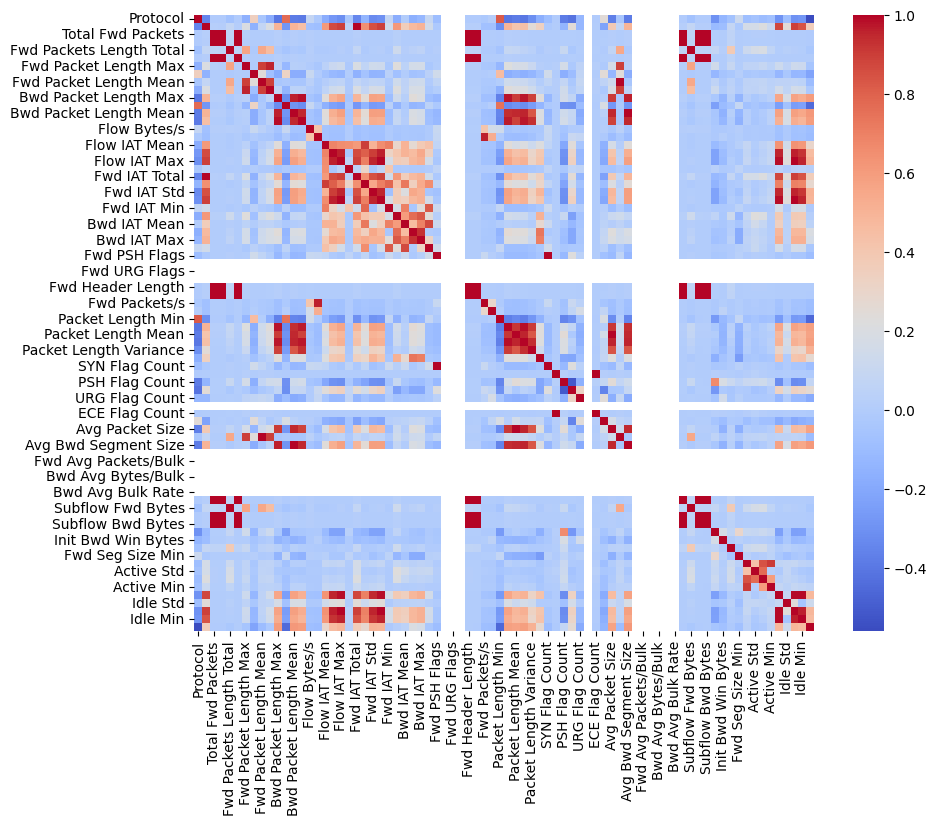

In [5]:
# correlation
plt.figure(figsize=(10, 8))
sns.heatmap(train_df.corr(), cmap='coolwarm', annot=False)
plt.show()

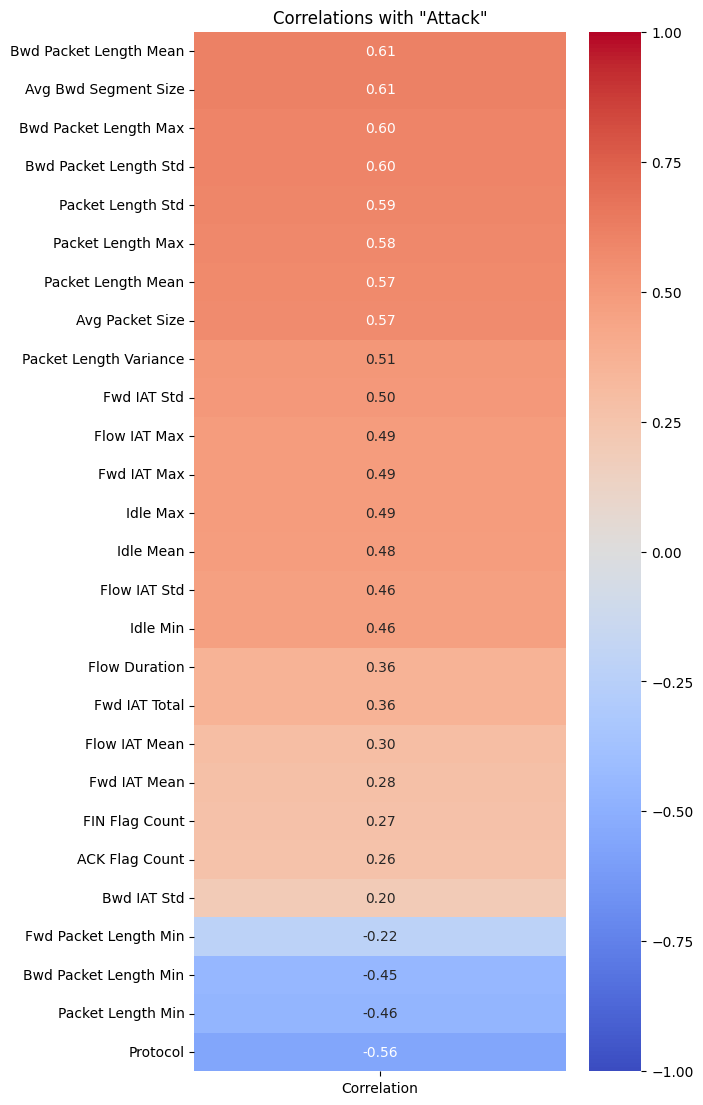

In [7]:
# Compute the correlation matrix
corr = train_df.corr()

# Extract correlations with 'Attack' greater than a threshold
threshold = 0.2  # Adjust this threshold to your needs
high_corr = corr['Attack'][corr['Attack'].abs() > threshold].drop('Attack')  # Exclude the correlation of 'Attack' with itself

# Convert to DataFrame for plotting
high_corr_df = pd.DataFrame(high_corr.sort_values(ascending=False))
high_corr_df.columns = ['Correlation']

# Plot
plt.figure(figsize=(6, len(high_corr_df) / 2))  # Adjust the figure size dynamically based on the number of features
sns.heatmap(high_corr_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title('Correlations with "Attack"')
plt.show()

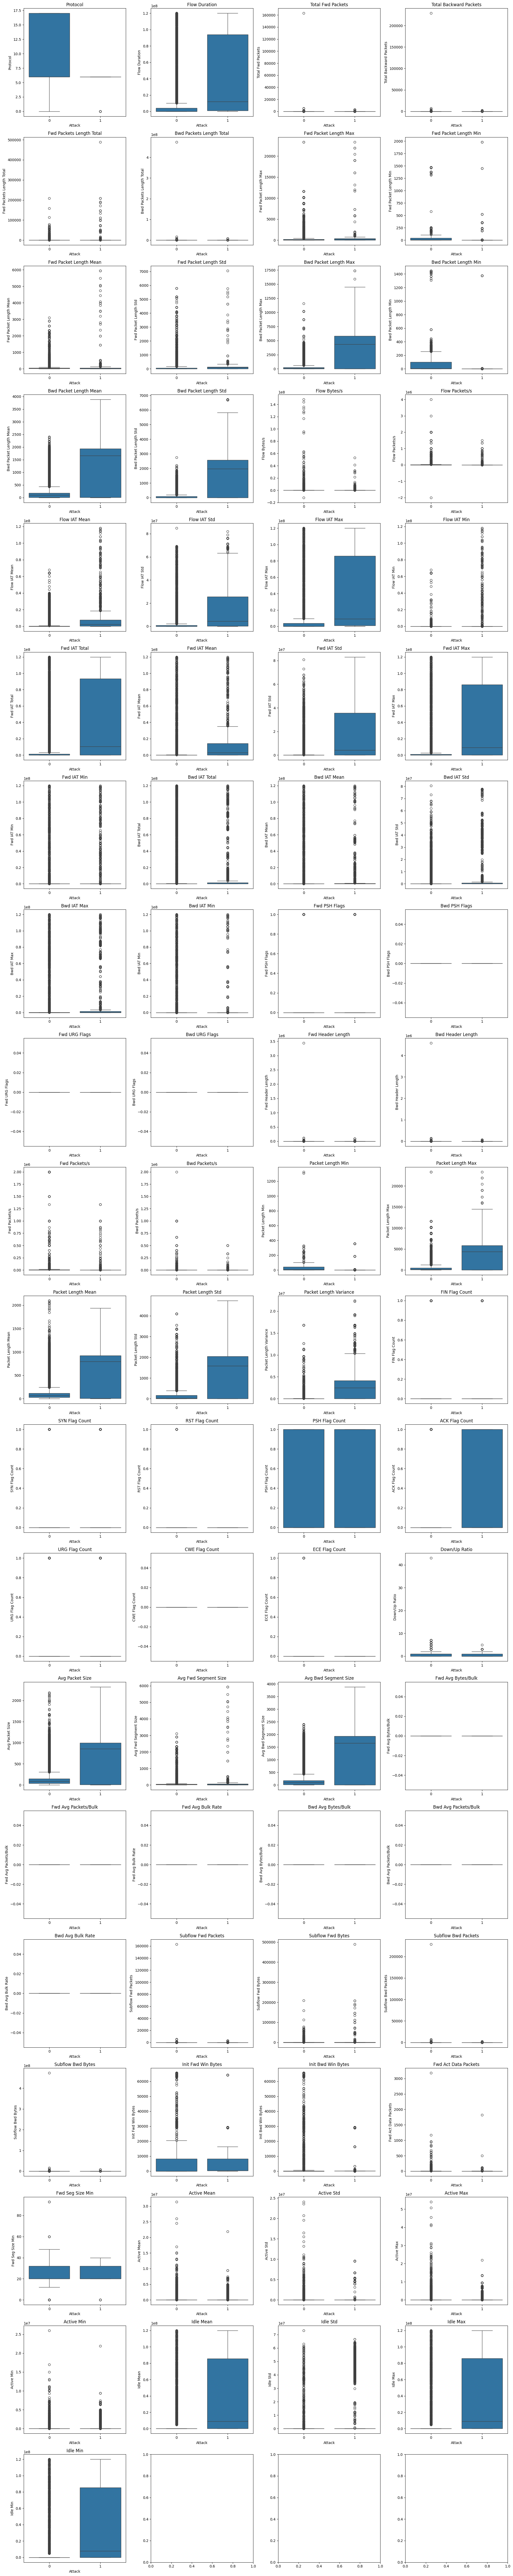

In [8]:
# Setting up the figure with multiple subplots
num_cols = 4
num_rows = (len(train_df.columns) - 1) // num_cols + 1  # Exclude 'Attack' and compute number of required rows

fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 5 * num_rows))  # Adjust size as needed
plot_idx = list(itertools.product(range(num_rows), range(num_cols)))

# Plot each feature except 'Attack'
for idx, c in zip(plot_idx, [col for col in train_df.columns if col != 'Attack']):
    if idx[0] == num_rows - 1 and idx[1] >= (len(train_df.columns) - 1) % num_cols:
        fig.delaxes(ax[idx[0]][idx[1]])  # Remove unused axes
    else:
        sns.boxplot(x='Attack', y=c, data=train_df, ax=ax[idx[0]][idx[1]])
        ax[idx[0]][idx[1]].set_title(c)

plt.tight_layout()
plt.show()

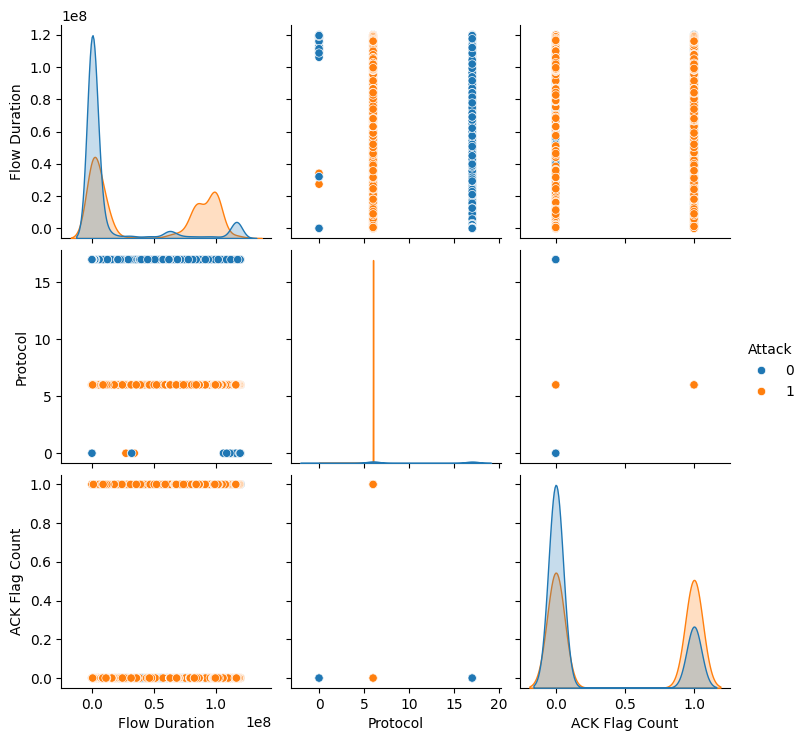

In [9]:
sns.pairplot(train_df[['Flow Duration', 'Protocol', 'ACK Flag Count', 'Attack']], hue='Attack')
plt.show()

# filtered features

In [ ]:
selected_features = [
    # also integrated results from random forest model:
    # IAT features
    'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
    'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min',
    # Flow features
    'Flow Duration', 'Fwd IAT Total',
    'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
    # Packet Length Features
    'Fwd Packet Length Min', 'Fwd Packets Length Total', 'Fwd Packet Length Max', 'Fwd Packet Length Mean',
    'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std',
    'Bwd Packets Length Total', 'Bwd Packet Length Max', 'Bwd Packets/s',
    'Packet Length Min', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
    'Total Fwd Packets', 'Total Backward Packets',
    # Additional selected features
    'Avg Packet Size', 'Fwd Act Data Packets', 'FIN Flag Count', 'ACK Flag Count', 
    'Init Fwd Win Bytes', 'Init Bwd Win Bytes',  'Protocol', 'Down/Up Ratio',  'Fwd Header Length',
    'Avg Fwd Segment Size','Avg Bwd Segment Size',
    'Bwd Header Length',
    # Attack
    'Attack'
]

# Create a new dataframe with only the selected features
train_df = train_df[selected_features]
train_df.head()

In [ ]:
X_train = train_df.drop(['Attack'], axis=1)
y_train = train_df['Attack']

In [12]:
# Fit a Random Forest to get feature importances
forest = RandomForestClassifier(n_estimators=100, random_state=42)
forest.fit(X_train, y_train)

# Select features based on importance weights
model = SelectFromModel(forest, prefit=True, threshold='mean')  # selecting features with importance greater than the mean importance
X_reduced = model.transform(X_train)
# Convert X_reduced back to a DataFrame for better usability
#X_reduced_df = pd.DataFrame(X_reduced, columns=X_train)

# See which features were selected
selected_features = X_train.columns[model.get_support()]
print("Selected features:", selected_features)


Selected features: Index(['Total Fwd Packets', 'Fwd Packets Length Total',
       'Bwd Packets Length Total', 'Fwd Packet Length Max',
       'Fwd Packet Length Mean', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow IAT Std', 'Fwd IAT Total',
       'Fwd IAT Mean', 'Fwd IAT Max', 'Fwd IAT Min', 'Fwd Header Length',
       'Bwd Header Length', 'Bwd Packets/s', 'Packet Length Max',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
       'Avg Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size',
       'Subflow Fwd Bytes', 'Subflow Bwd Bytes', 'Init Fwd Win Bytes',
       'Init Bwd Win Bytes'],
      dtype='object')


/work/SarahHvidAndersen#6681/env/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


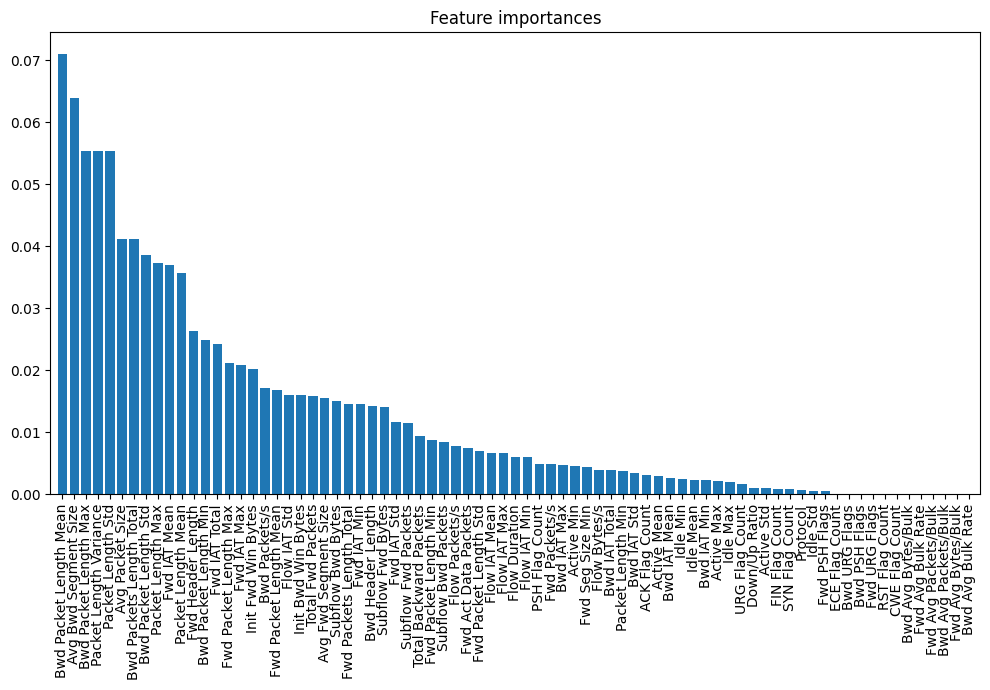

In [13]:
feature_importances = forest.feature_importances_
indices = np.argsort(feature_importances)[::-1]  # Sort feature importances in descending order

plt.figure(figsize=(12, 6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [ ]:
feature_importances = forest.feature_importances_
indices = np.argsort(feature_importances)[::-1]  # Sort feature importances in descending order

plt.figure(figsize=(12, 6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

with features reduced based on corr and boxplot:
Selected features: = 14
        'Index['Fwd IAT Total', 'Fwd IAT Mean', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'Avg Packet Size',
       'Init Fwd Win Bytes', 'Avg Bwd Segment Size', 'Avg Fwd Segment Size'],

using all features:
Selected features: = 28
        ['Total Fwd Packets', 'Fwd Packets Length Total',
       'Bwd Packets Length Total', 'Fwd Packet Length Max',
       'Fwd Packet Length Mean', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow IAT Std', 'Fwd IAT Total',
       'Fwd IAT Mean', 'Fwd IAT Max', 'Fwd IAT Min', 'Fwd Header Length',
       'Bwd Header Length', 'Bwd Packets/s', 'Packet Length Max',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
       'Avg Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size',
       'Subflow Fwd Bytes', 'Subflow Bwd Bytes', 'Init Fwd Win Bytes',
       'Init Bwd Win Bytes'],

using features from pre-select and rf: = 15
        Index(['Fwd IAT Total', 'Fwd Packet Length Max', 'Bwd Packet Length Max',
        'Bwd Packet Length Mean', 'Bwd Packet Length Std',
        'Bwd Packets Length Total', 'Bwd Packet Length Max',
        'Packet Length Max', 'Packet Length Mean', 'Packet Length Std',
        'Packet Length Variance', 'Avg Packet Size', 'Fwd Header Length',
        'Avg Fwd Segment Size', 'Avg Bwd Segment Size'],